In [28]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [29]:
# function for aurgumentation
transform = A.Compose([
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.Rotate(limit=40, p=0.9),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1)
    ], p=1.0),
])


In [30]:
os.listdir(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset')


['no', 'yes']

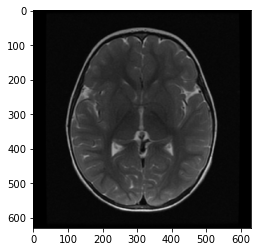

In [31]:
temp = Image.open(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/2 no.jpeg')
plt.imshow(temp)


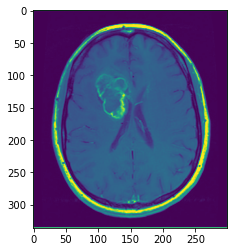

In [32]:
temp = Image.open(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y101.jpg')
plt.imshow(temp)


In [33]:
# function for loading images from given directory path and returning the images list and respective labels list
def Load_img(img_path):
    # images list
    imgs = []
    # labels list
    labels = []
    # list to store all directory names in given path
    l1 = os.listdir(img_path)
    for i in l1:
        # list to store all image name in given 'i' directory
        l2 = os.listdir(img_path+'/'+i)
        for j in l2:
            # opening image with path using Image.open()
            img = Image.open(img_path+'/'+i+'/'+j)
            # resizing image to  size
            img = img.resize(size=(50, 50))
            # changing image dimensions to 2D ie. gray scale
            img = img.convert('L')
            # converting to np array
            img = np.array(img)
            # list to store agumented images of one image
            image_list = []
            image_list.clear() # making the list empty for each iteration
            # augumentation
            for p in range(10):
                augumentations = transform(image=img)
                augumentation_image = augumentations["image"]
                image_list.append(augumentation_image)
            for k in image_list:
                # adding image to imgs( list of all images )
                imgs.append(k)
                # adding label to label list
                labels.append(i)
                # deleting the loaded image
                del k
            # deleting the 'img' image
            del img
    # returning numpy array of 'imgs' and labels as a list
    return np.array(imgs), labels


In [34]:
# loading dataset into x,y using 'Load_img' function written above
# 'img_path' is dataset path
img_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
x, y = Load_img(img_path)


In [35]:
x.shape


(2530, 50, 50)

In [36]:
print(len(y))


2530


In [37]:
x[0].shape
# each image shape

(50, 50)

In [38]:
target = pd.Series(y, dtype='category')
t = target.cat.codes


In [39]:
dicti = dict(enumerate(target.cat.categories))


In [40]:
print(dicti)
# classes that are being predicted

{0: 'no', 1: 'yes'}


In [41]:
# splitting data into training, validation, testing datasets
train_x, test_x, train_y, test_y = train_test_split(
    x, t, test_size=0.1, random_state=100, shuffle=True)
train_x, valid_x, train_y, valid_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=100, shuffle=True)
# printing shapes of train, valid, test
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape

((1821, 50, 50), (1821,), (456, 50, 50), (456,), (253, 50, 50), (253,))

In [42]:
print("Number of training images: ", train_x.shape[0])
print("Number of validation images: ", valid_x.shape[0])
print("Number of testing images: ", test_x.shape[0])
# printing number of images in training, validation, testing

Number of training images:  1821
Number of validation images:  456
Number of testing images:  253


In [43]:
# importing Renet101 model from tensorflow
model = tf.keras.applications.resnet.ResNet101(
    weights=None,
    input_tensor=None,
    input_shape=(50, 50, 1),
    pooling=max,
    classes=2
)


In [44]:
model.summary()


Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [45]:
# using loss: sparse_categorical_crossentropy and optimizer: adam
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


In [46]:
# Early Stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


In [47]:
'''training the model with
    batch_size: 32,
    epochs=60, with Early Stopping,
    including validation_data
'''
history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(
    valid_x, valid_y), shuffle=True, verbose=1, callbacks=[es])


Epoch 1/50
114/114 [==============================] - 21s 98ms/step - loss: 1.0198 - accuracy: 0.7392 - val_loss: 1.6279 - val_accuracy: 0.4167
Epoch 2/50
114/114 [==============================] - 9s 81ms/step - loss: 0.8105 - accuracy: 0.7106 - val_loss: 16.6146 - val_accuracy: 0.6557
Epoch 3/50
114/114 [==============================] - 9s 77ms/step - loss: 0.5796 - accuracy: 0.7655 - val_loss: 1.0394 - val_accuracy: 0.7061
Epoch 4/50
114/114 [==============================] - 9s 79ms/step - loss: 0.3153 - accuracy: 0.8726 - val_loss: 0.2020 - val_accuracy: 0.9189
Epoch 5/50
114/114 [==============================] - 9s 79ms/step - loss: 0.2534 - accuracy: 0.9072 - val_loss: 0.3243 - val_accuracy: 0.8465
Epoch 6/50
114/114 [==============================] - 9s 81ms/step - loss: 0.1149 - accuracy: 0.9550 - val_loss: 0.0693 - val_accuracy: 0.9803
Epoch 7/50
114/114 [==============================] - 9s 78ms/step - loss: 0.1340 - accuracy: 0.9610 - val_loss: 0.0971 - val_accuracy: 0.96

In [48]:
_, train_acc = model.evaluate(train_x, train_y)
_, test_acc = model.evaluate(test_x, test_y)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# printing accuracy for train and test

8/8 [==============================] - 0s 30ms/step - loss: 0.0213 - accuracy: 0.9960
Train: 1.000, Test: 0.996


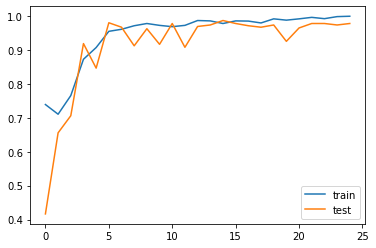

In [49]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


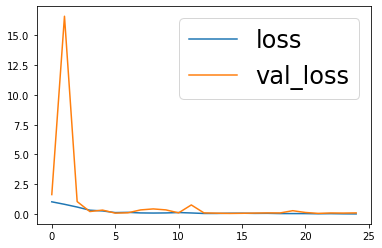

In [50]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24})


In [51]:
# Saving the model for Future Inferences
model_json = model.to_json()
with open("./model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./model.h5")

In [52]:
# function for prediction whether there is a brain tumor or not
def Prediction(img):
    # resizing the image to resizing 50x50 and converting it to numpy array
    x = np.array(img.resize((50, 50)))
    x = x.reshape(1, 50, 50)
    # predicting using the model
    res = model.predict(x)
    classification = np.where(res == np.amax(res))[1][0]
    # showing the image given
    plt.imshow(img)
    # printing the result
    print(str(res[0][classification]*100) +
          '% Confidence ' + dicti[classification])


99.99773502349854% Confidence no


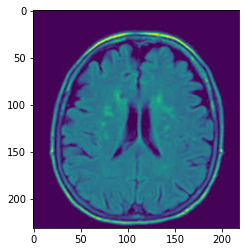

In [53]:
img = Image.open(
    r"/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/17 no.jpg").convert('L')
Prediction(img)


99.99773502349854% Confidence no


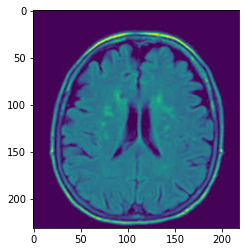

In [54]:
img = Image.open(
    r"/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/17 no.jpg").convert('L')
Prediction(img)
